In [1]:
!pip install mitiq
!pip install qiskit
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 5.2 MB/s 
     |████████████████████████████████| 15.3 MB 41.6 MB/s 
     |████████████████████████████████| 576 kB 46.4 MB/s 
     |████████████████████████████████| 1.8 MB 6.9 MB/s 
     |████████████████████████████████| 66 kB 3.6 MB/s 
     |████████████████████████████████| 57 kB 3.4 MB/s 
     |████████████████████████████████| 594 kB 44.0 MB/s 
     |████████████████████████████████| 115 kB 45.5 MB/s 
     |████████████████████████████████| 221 kB 57.1 MB/s 
     |████████████████████████████████| 44 kB 2.7 MB/s 
     |████████████████████████████████| 147 kB 39.3 MB/s 
     |████████████████████████████████| 221 kB 41.3 MB/s 
     |████████████████████████████████| 229 kB 39.4 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 68

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 4.7 MB/s 
     |████████████████████████████████| 19.2 MB 8.4 MB/s 
     |████████████████████████████████| 240 kB 41.6 MB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 106 kB 47.1 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 37.5 MB 29 kB/s 
     |████████████████████████████████| 943 kB 40.3 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 4.1 MB 9.2 MB/s 
     |████████████████████████████████| 1.9 MB 43.3 MB/s 
     |████████████████████████████████| 112 kB 46.8 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12224 sha256=d969ecbe031f08a4bc48c0e761e28ff0b5d6f24be911c866ce55ea778bebec13
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee55cc

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import sys
#sys.path.insert(0,'/content/drive/My Drive/QDNN')
path_to_module = '/content/gdrive/My Drive/QDNN_time_series_ver1'
sys.path.append(path_to_module)

In [4]:
import json
import Exact_diagonalization as ed
from scipy.sparse.linalg import expm_multiply

import numpy as np
import pickle
import matplotlib.pyplot as plt

def dyn(Total_time,time_steps,ham,init_state):
    
    state_t=np.zeros((2**L,time_steps+1),dtype=complex)
    
    state_t[:,0]=init_state
    
    for i in range(time_steps):
        
        state_t[:,i+1]=expm_multiply(-1j*dt*ham,state_t[:,i])
        
    return state_t

def z_exp_val(sp,i,state_t,time_steps):
    sz=sp.spin_z(i)
    exp_z=[]
    for i in range(time_steps):
        
        exp_z.append(np.dot(np.conjugate(state_t[:,i]),sz.dot(state_t[:,i])))
        
    return np.real(exp_z)

def y_exp_val(sp,i,state_t,time_steps):
    sy=sp.spin_y(i)
    exp_y=[]
    for i in range(time_steps):
        
        exp_y.append(np.dot(np.conjugate(state_t[:,i]),sy.dot(state_t[:,i])))
        
    return np.real(exp_y)

def x_exp_val(sp,i,state_t,time_steps):
    sx=sp.spin_x(i)
    exp_x=[]
    for i in range(time_steps):
        
        exp_x.append(np.dot(np.conjugate(state_t[:,i]),sx.dot(state_t[:,i])))
        
    return np.real(exp_x)
        
def reduced_1_spin_density_matrix(state_vector,pos):
    num_cb=len(state_vector)
    sys_size=int(np.log(num_cb)/np.log(2))
    dic={}
    dic['1']=[]
    dic['0']=[]
    for i in range(num_cb):
        bit_string=format(i,'0{}b'.format(sys_size))[::-1]
        if bit_string[pos]=='1':
            dic['1']+=[state_vector[i]]
        elif bit_string[pos]=='0':
            dic['0']+=[state_vector[i]]
            
    density_matrix=np.zeros((2,2),dtype=complex)
    density_matrix[0,0]=np.conjugate(dic['0']).dot(dic['0'])
    density_matrix[1,0]=np.conjugate(dic['1']).dot(dic['0'])
    density_matrix[0,1]=np.conjugate(dic['0']).dot(dic['1'])
    density_matrix[1,1]=np.conjugate(dic['1']).dot(dic['1'])
    
    return density_matrix

def data_density_matrix_saving_encoding_1(Density_data_t,tv_ratio,num_encoding=1):
    if isinstance(Density_data_t[0], np.ndarray):
        tot_data_num=len(Density_data_t)-num_encoding
        num_train_data=int(tot_data_num*tv_ratio)
        num_val_data=tot_data_num-num_train_data
        train_data={}
        train_data['input']=[]
        train_data['output']=[]

        val_data={}
        val_data['input']=[]
        val_data['output']=[]
        
        for i in range(num_train_data):
            matrix_t=Density_data_t[i]
            for j in range(1,num_encoding):
                matrix_t=np.kron(Density_data_t[i+j],matrix_t)

            train_data['input'].append(matrix_t)
            train_data['output'].append(Density_data_t[i+num_encoding])
        path_dir='opflow_train_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

        for i in range(num_val_data):
            matrix_t=Density_data_t[num_train_data+i]
            for j in range(1,num_encoding):
                matrix_t=np.kron(Density_data_t[num_train_data+i+j],matrix_t)

            val_data['input'].append(matrix_t)
            val_data['output'].append(Density_data_t[num_train_data+i+num_encoding])
        path_dir='opflow_val_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    elif isinstance(Density_data_t[0], list):

        Density_data_len=len(Density_data_t)
      
        tot_data_num=len(Density_data_t[0])-num_encoding
        num_train_data=int(tot_data_num*tv_ratio)
        num_val_data=tot_data_num-num_train_data
        train_data={}
        train_data['input']=[]
        train_data['output']=[]

        val_data={}
        val_data['input']=[]
        val_data['output']=[]
        for i in range(num_train_data):
            matrix_t=Density_data_t[0][i]
            for j in range(1,Density_data_len):
                matrix_t=np.kron(Density_data_t[j][i],matrix_t)
            for j in range(1,num_encoding):
                for i_density in Density_data_t:
                    matrix_t=np.kron(i_density[i+j],matrix_t)

            train_data['input'].append(matrix_t)
            train_data['output'].append(Density_data_t[0][i+num_encoding])
        path_dir='opflow_train_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

        for i in range(num_val_data):
            matrix_t=Density_data_t[0][num_train_data+i]
            for j in range(1,Density_data_len):
                matrix_t=np.kron(Density_data_t[j][num_train_data+i],matrix_t)
            for j in range(1,num_encoding):
                for i_density in Density_data_t:
                    matrix_t=np.kron(i_density[num_train_data+i+j],matrix_t)

            val_data['input'].append(matrix_t)
            val_data['output'].append(Density_data_t[0][num_train_data+i+num_encoding])
        path_dir='opflow_val_data_set'
        with open(path_dir, 'wb') as handle:
            pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

def densit_matrix(X_val,Y_val,Z_val):
    X=np.zeros((2,2),dtype=int)
    Y=np.zeros((2,2),dtype=complex)
    Z=np.zeros((2,2),dtype=int)
    X[0,1]=X[1,0]=1
    Y[0,1]=-1j
    Y[1,0]=1j
    Z[0,0]=1
    Z[1,1]=-1
    
    DM=[]
    num=len(X_val)
    for i in range(num):
        DM.append((np.eye(2)+X_val[i]*X+Y_val[i]*Y+Z_val[i]*Z)/2)
    return DM

In [5]:
from scipy.sparse import identity

#Encoding with correlation

def string_2_op(sp,site,string):
   if string=='I':
      return identity(2**sp.sys_size)# np.eye(2**sp.sys_size)
   elif string=='X':
      return sp.spin_x(site)
   elif string=='Y':
      return sp.spin_y(site)
   elif string=='Z':
      return sp.spin_z(site)

def string_2_pauli(string):
   X=np.zeros((2,2),dtype=int)
   Y=np.zeros((2,2),dtype=complex)
   Z=np.zeros((2,2),dtype=int)
   X[0,1]=X[1,0]=1
   Y[0,1]=-1j
   Y[1,0]=1j
   Z[0,0]=1
   Z[1,1]=-1
    
   if string=='I':
      return np.eye(2)
   elif string=='X':
      return X
   elif string=='Y':
      return Y
   elif string=='Z':
      return Z

def m4by4_entsngled_density(sp,i_site,j_site,state_t,time_steps):
   pauli_matrix=['I','X','Y','Z']
   #m4by4=np.zeros(4,4,dytpe=complex)
   d_t=[0]*time_steps
   cor={}
   for i_m in pauli_matrix:
      for j_m in pauli_matrix:
          if i_m=='I' and j_m=='I':
              #m4by4+=np.eye(4)/4
              for step in range(time_steps):
                  d_t[step]=np.eye(4, dtype=complex)/4
              continue
          else:
              cor[i_m+j_m]=[]
              op1=string_2_op(sp,i_site,i_m)
              op2=string_2_op(sp,j_site,j_m)
              ob=op1.dot(op2)

              m_1=string_2_pauli(i_m)
              m_2=string_2_pauli(j_m)
              matrix_op=np.kron(m_1,m_2)
              for step in range(time_steps):
                  exp_val_t=np.dot(np.conjugate(state_t[:,step]),ob.dot(state_t[:,step]))
                  cor[i_m+j_m].append(exp_val_t)
                  d_t[step]+=matrix_op*exp_val_t/4
   return  d_t, cor

def data_density_matrix_saving_encoding_2(Density_data_t_input,Density_data_t_output,tv_ratio,num_encoding=1):
    tot_data_num=len(Density_data_t_input)-num_encoding
    num_train_data=int(tot_data_num*tv_ratio)
    num_val_data=tot_data_num-num_train_data
    train_data={}
    train_data['input']=[]
    train_data['output']=[]

    val_data={}
    val_data['input']=[]
    val_data['output']=[]
    
    for i in range(num_train_data):
        matrix_t=Density_data_t_input[i]
        for j in range(1,num_encoding):
            matrix_t=np.kron(Density_data_t_input[i+j],matrix_t)

        train_data['input'].append(matrix_t)
        train_data['output'].append(Density_data_t_output[i+num_encoding])
    path_dir='opflow_train_data_set'
    with open(path_dir, 'wb') as handle:
        pickle.dump(train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    for i in range(num_val_data):
        matrix_t=Density_data_t_input[num_train_data+i]
        for j in range(1,num_encoding):
            matrix_t=np.kron(Density_data_t_input[num_train_data+i+j],matrix_t)

        val_data['input'].append(matrix_t)
        val_data['output'].append(Density_data_t_output[num_train_data+i+num_encoding])
    path_dir='opflow_val_data_set'
    with open(path_dir, 'wb') as handle:
        pickle.dump(val_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
L=10
sp=ed.spin_half_system(L)    
# create system hamiltonian

i_site=L-1 # where system locate
hx=1
ham_S=hx*(sp.spin_x(i_site))#+sp.spin_y(i_site))

# Create environment ham w/ open boundary condition (Heisenberg model)
ham_E=0
hz=1
Jzz=1
Jxy=1
for i in range(L):
    if i != i_site: 
        ham_E+=hz*sp.spin_x(i)#*((-1)**(i))
    if i != i_site and i+1 !=i_site and i != L-1:        
        ham_E+=Jzz*sp.spin_z(i).dot(sp.spin_z(i+1))           

        
# Creating the interaction Hamiltonian
ham_SE=0
Jzz=1

ham_SE+=Jzz*sp.spin_z(i_site-1).dot(sp.spin_z(i_site))
#ham_SE+=Jzz*sp.spin_x(i_site-1).dot(sp.spin_x(i_site))
# Total Hamtonian  
tot_h=ham_SE+ham_E+ham_S   
Total_time=10

time_steps=100
dt=Total_time/time_steps
state_t=np.zeros((2**L,time_steps+1),dtype=complex)

init_state=np.zeros(2**L) ##np.ones(2**L, dtype=int)/np.sqrt(2**L)
#init_state=np.ones(2**L, dtype=int)/np.sqrt(2**L)
#f=1  # |1000000000> |>

init_state[0]=1/np.sqrt(2) # |+000000000>=(|1000000000>+|1000000000>)/np.sqrt(2)
init_state[1]=1/np.sqrt(2)


state_t=dyn(Total_time,time_steps,tot_h,init_state)

y_exp=y_exp_val(sp,i_site,state_t,time_steps+1)
z_exp=z_exp_val(sp,i_site,state_t,time_steps+1)
x_exp=x_exp_val(sp,i_site,state_t,time_steps+1)

y_exp_1=y_exp_val(sp,i_site-1,state_t,time_steps+1)
z_exp_1=z_exp_val(sp,i_site-1,state_t,time_steps+1)
x_exp_1=x_exp_val(sp,i_site-1,state_t,time_steps+1)

DM=densit_matrix(x_exp,y_exp,z_exp)
#DM_1=densit_matrix(x_exp_1,y_exp_1,z_exp_1)
j_site=i_site-1
DM_2, corr=m4by4_entsngled_density(sp,i_site,j_site,state_t,time_steps+1)

#DM_lst=[DM,DM_1]
#density_matrix=[]
#for i in range(time_steps):
#    density_matrix.append(reduced_1_spin_density_matrix(state_t[:,i],i_site)) 
num_encoding=3
data_density_matrix_saving_encoding_2(DM_2,DM,0.8,num_encoding=num_encoding)

path_dir='opflow_train_data_set'

with open(path_dir, 'rb') as handle:       
      train_data = pickle.load(handle)
path_dir='opflow_val_data_set'

with open(path_dir, 'rb') as handle:
        
      val_data = pickle.load(handle)

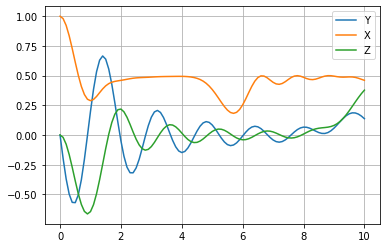

In [7]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,y_exp,label='Y')
plt.plot(Time,x_exp,label='X')
plt.plot(Time,z_exp,label='Z')
plt.legend()
plt.grid()

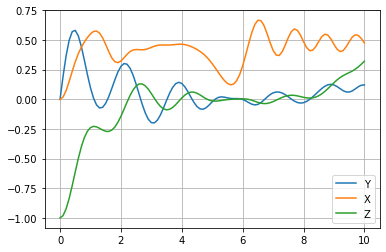

In [8]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,y_exp_1,label='Y')
plt.plot(Time,x_exp_1,label='X')
plt.plot(Time,z_exp_1,label='Z')
plt.legend()
plt.grid()

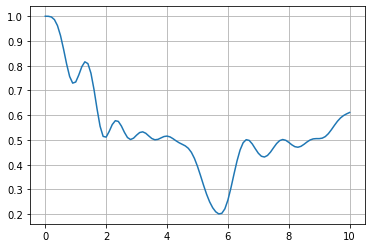

In [9]:
Dist_R=np.sqrt(y_exp**2+x_exp**2+z_exp**2)
plt.plot(Time,Dist_R)
plt.grid()

In [10]:
import numpy as np
from typing import Union, List, Callable
from collections import deque

from qiskit.quantum_info import random_unitary, random_density_matrix, random_statevector
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, state_fidelity
from qiskit.quantum_info.states.quantum_state import Operator
from qiskit.extensions import HamiltonianGate

from qiskit.algorithms.optimizers import SPSA, ADAM

from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

In [11]:
class OpflowDQNN(object):

    def __init__(self, qnnArch:List[int], epsilon:float=0.1, lamda:float=1):
        """ Deep Quantum Neural Network 
        Args:
            qnnArch: list of integers representing the architecture of the DQNN. e.g. [2, 3, 2] represents 2q input, 3q hidden, 2q output
        """
        self.qnnArch = qnnArch
        self.epsilon = epsilon
        self.lamda = lamda

    def makeRandomUnitaries(self, seed:int=None):
        """ Randomly initialize the unitaries of the DQNN
        Args:
            seed: random seed
        """
        unitaries = []
        for l in range(len(self.qnnArch)-1):
            unitaries.append(
                np.empty(
                    shape=(self.qnnArch[l+1], 2**(self.qnnArch[l]+1), 2**(self.qnnArch[l]+1)), 
                    dtype=np.complex128
                )
            )
            for j in range(self.qnnArch[l+1]):
                unitaries[l][j, : :] = random_unitary(2**(self.qnnArch[l]+1), seed=(seed+j) if seed is not None else None).data
        return unitaries

    def applyLayerChannel(self, unitaries:List[np.ndarray], l:int, inputState:DensityMatrix):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # inputState = DensityMatrix(inputState)
        inputState = inputState.expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
        # apply layer unitaries
        for j in range(numOutputQubits):
            # assert Operator(layerUnitaries[j, :, :]).is_unitary(), f"`unitaries[{l}][{j}, :, :]` is not unitary"
            inputState = inputState.evolve(Operator(layerUnitaries[j, : , :]), qargs=inputWires+[outputWires[j]])
        return partial_trace(inputState, qargs = inputWires)

    def applyAdjointLayerChannel(self, unitaries:List[np.ndarray], l:int, outputState:DensityMatrix):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # outputState = DensityMatrix(outputState)
        outputState = DensityMatrix(np.eye(2**numInputQubits)).expand(outputState)
        projOp = Operator(np.eye(2**numInputQubits)).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits).to_operator())
        # apply adjoing layer unitaries
        for j in range(numOutputQubits-1, -1, -1):
            # assert Operator(layerUnitaries[j, :, :]).is_unitary(), f"`unitaries[{l}][{j}, :, :]` is not unitary"
            outputState = outputState.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
        return partial_trace(DensityMatrix(projOp @ outputState.to_operator()), outputWires)

    def feedforward(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Forward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, output_dim, output_dim)" per layer
        """
        forward_process = []
        for quantum_state in inputs:
            layer_output = deque()
            quantum_state = DensityMatrix(quantum_state)
            layer_output.append(quantum_state)
            for l in range(len(self.qnnArch)-1):
                quantum_state = self.applyLayerChannel(unitaries, l, quantum_state)
                layer_output.append(quantum_state)
            forward_process.append(layer_output)

        layer_outputs = []
        for l in range(len(self.qnnArch)):
            layer_outputs.append(np.stack([forward_process[x][l] for x in range(len(inputs))]))
        return layer_outputs

    def backpropagation(self, unitaries:List[np.ndarray], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Backward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputs: deque of "array of layer states of shape (batch_size, input_dim, input_dim)" per layer
        """
        backward_process = []
        for povm_measurement in targets:
            layer_output = deque()
            povm_measurement = DensityMatrix(povm_measurement)
            layer_output.appendleft(povm_measurement)
            for l in range(len(self.qnnArch)-2, -1, -1):
                povm_measurement = self.applyAdjointLayerChannel(unitaries, l, povm_measurement)
                layer_output.appendleft(povm_measurement)
            backward_process.append(layer_output)

        layer_outputs = []
        for l in range(len(self.qnnArch)):
            layer_outputs.append(np.stack([backward_process[x][l] for x in range(len(targets))]))
        return layer_outputs

    def step(self, unitaries:List[np.ndarray], inputs:List[Union[Statevector, DensityMatrix, np.ndarray]], targets:List[Union[Statevector, DensityMatrix, np.ndarray]]):
        """ Perform a single step of the DQNN
        Args:
            unitaries: list of unitary parameters per layer. This will be updated in-place.
            inputs: array of input states of shape (batch_size, input_dim, input_dim) or (batch_size, input_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            outputstate: array of (previous) output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
        Note:
            This update is only suitable for state fidelity cost function.
        """
        # feedforward & backpropagation
        feedforward_results = self.feedforward(unitaries, inputs)
        backpropagation_results = self.backpropagation(unitaries, targets)

        for l in range(len(self.qnnArch)-1):
            xTrMmatrices = []
            numInputQubits = self.qnnArch[l]
            numOutputQubits = self.qnnArch[l+1]
            inputWires = list(range(numInputQubits))
            outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
            layerUnitaries = unitaries[l]
            layerInputStates = feedforward_results[l]
            layerOutputStates = backpropagation_results[l+1]
            # make update matrices
            for layerInputState, layerOutputState in zip(layerInputStates, layerOutputStates):
                Amatrices = deque()
                Bmatrices = deque()
                TrMmatrices = list()
                astate = DensityMatrix(layerInputState).expand(DensityMatrix.from_int(0, dims=2**numOutputQubits))
                bstate = DensityMatrix(np.eye(2**numInputQubits)).expand(DensityMatrix(layerOutputState))
                for j in range(numOutputQubits):
                    astate = astate.evolve(layerUnitaries[j, :, :], qargs=inputWires+[outputWires[j]])
                    Amatrices.append(astate.data)
                for j in range(numOutputQubits-1, -1, -1):
                    Bmatrices.appendleft(bstate.data)
                    if j != 0:
                        bstate = bstate.evolve(Operator(layerUnitaries[j, :, :]).adjoint(), qargs=inputWires+[outputWires[j]])
                for j in range(numOutputQubits):
                    # assert np.isclose(np.trace(Amatrices[j] @ Bmatrices[j]) , np.mean(measout[:, x])), "A or B matrix is incorrect"
                    TrMmatrices.append(partial_trace(self._commutator(Amatrices[j], Bmatrices[j]), qargs=outputWires[:j]+outputWires[j+1:]).data)
                    # assert TrMmatrices[j].shape == layerUnitaries[j].shape, f"TrM matrix is incorrect ({TrMmatrices[-1].shape} != {layerUnitaries.shape})"
                xTrMmatrices.append(TrMmatrices)
            xTrMmatrices = np.stack(xTrMmatrices)
            Kmatrices = 1j * (2**numInputQubits) / self.lamda * xTrMmatrices.mean(axis=0)
            # assert len(xTrMmatrices)==len(targets)
            # replace unitaries
            for j in range(numOutputQubits):
                # assert Operator(Kmatrices[j]) == Operator(Kmatrices[j]).adjoint()
                unitaries[l][j, :, :] = np.matmul(HamiltonianGate(Kmatrices[j], time=-self.epsilon).to_matrix(), unitaries[l][j, :, :])
                # assert Operator(unitaries[l][j, :, :]).is_unitary()
        return self.cost(feedforward_results[-1], targets)

    @staticmethod
    def cost(outputs:np.ndarray, targets:np.ndarray):
        """ Calculate the cost of the DQNN
        Args:
            outputs: array of output states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)
            targets: array of target states of shape (batch_size, output_dim, output_dim) or (batch_size, output_dim)

        Returns: 
            cost: float
        """
        # assert len(outputs) == len(targets)
        cost = 0
        for output, target in zip(outputs, targets):
            cost += state_fidelity(DensityMatrix(output), DensityMatrix(target))
        return cost/len(targets)

    @staticmethod
    def _commutator(A, B):
        # assert A.shape == B.shape
        # assert len(A.shape) == 2
        return np.matmul(A, B) - np.matmul(B, A)


    def __call__(self, unitaries, inputs):
        return self.feedforward(unitaries, inputs)[-1]

In [12]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

param = RealAmplitudes(num_qubits=2, reps=3).parameters
RealAmplitudes(num_qubits=2, reps=3).num_parameters

qc = QuantumCircuit(5)
for i in range(2, 5):
    _qc = RealAmplitudes(num_qubits=3, reps=1)
    qc.compose(_qc.assign_parameters(ParameterVector(f'theta{i}', _qc.num_parameters)), [0, 1, i], inplace=True)
qc.num_parameters

18

In [13]:
def generate_random_training_data(numSamples:int, numInputQubits:int, seed:int=None):
    """ Generate random training data 
    Args:
        numSamples: number of samples to generate
        numInputQubits: number of input qubits
    Returns:
        trainingData: array of input states of shape (batch_size, 2**numInputQubits)
    """
    trainingData = np.empty(shape=(numSamples, 2**numInputQubits), dtype=np.complex128)
    for i in range(numSamples):
        trainingData[i, :] = random_statevector(2**numInputQubits, seed=(seed+i) if seed is not None else None).data
    return trainingData

def generate_target_from_unitary(channel:Operator, trainingData:list):
    """ Generate target states from a channel
    Args:
        channel: quantum channel or unitary to apply to the training data
        trainingData: list of input states
    Returns:
        targets: array of target states of shape (batch_size, output_dim) or (batch_size, output_dim, output_dim)
    """
    targetStates = []
    for inputState in trainingData:
        inputState = Statevector(inputState)
        targetStates.append(
            inputState.evolve(channel).data
        )
    targetStates = np.stack(targetStates)
    return targetStates

    


In [15]:
#unitary = random_unitary(2**2)
deg_DM=2#len(DM_lst)

model = OpflowDQNN([num_encoding*deg_DM, 2, 1], epsilon=0.01)
unitaries = model.makeRandomUnitaries()
trainingData = train_data['input']#generate_random_training_data(10, 2, seed=0)
targetStates = train_data['output']#generate_target_from_unitary(unitary, trainingData)

val_Data = val_data['input']#generate_random_training_data(10, 2, seed=0)
val_targetStates = val_data['output']#generate_target_from_unitary(unitary, trainingData)

train_loss_list = []
val_loss_list = []
writer = SummaryWriter(log_dir='./runs/DQNN')
for s in trange(50):
    loss = model.step(unitaries, trainingData, targetStates)
    writer.add_scalar('Loss', loss, s)
    train_loss_list.append(loss)
    feedforward_results=model.feedforward(unitaries, val_Data)
    val_loss=model.cost(feedforward_results[-1],val_targetStates )
    val_loss_list.append(val_loss)

100%|██████████| 50/50 [44:33<00:00, 53.48s/it]


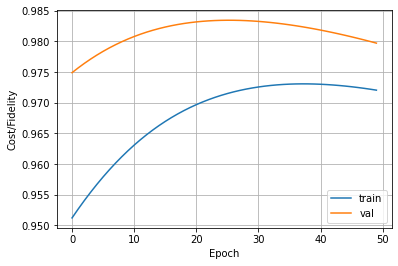

In [16]:

plt.plot(train_loss_list,label='train')
plt.plot(val_loss_list,label='val')
plt.xlabel('Epoch')
plt.ylabel('Cost/Fidelity')
plt.legend()
plt.grid()

In [17]:
X=np.zeros((2,2),dtype=int)
Y=np.zeros((2,2),dtype=complex)
Z=np.zeros((2,2),dtype=int)
X[0,1]=X[1,0]=1
Y[0,1]=-1j
Y[1,0]=1j
Z[0,0]=1
Z[1,1]=-1
tot_data=trainingData+val_Data
feedforward_results=model.feedforward(unitaries, tot_data)
X_predict=[x_exp[i] for i in range(num_encoding)]
Y_predict=[y_exp[i] for i in range(num_encoding)]
Z_predict=[z_exp[i] for i in range(num_encoding)]
num=len(feedforward_results[-1])
for i in range(num):
    X_predict.append(np.real(np.trace(feedforward_results[-1][i].dot(X))))
    Y_predict.append(np.real(np.trace(feedforward_results[-1][i].dot(Y))))
    Z_predict.append(np.real(np.trace(feedforward_results[-1][i].dot(Z))))

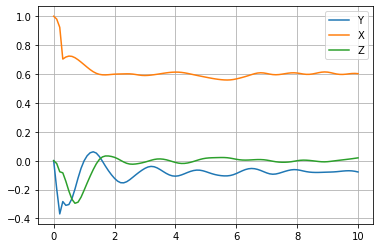

In [18]:
Time=np.linspace(0,Total_time,time_steps+1)
plt.plot(Time,Y_predict,label='Y')
plt.plot(Time,X_predict,label='X')
plt.plot(Time,Z_predict,label='Z')
plt.legend()
plt.grid()

In [19]:
Z_predict=np.array(Z_predict)
X_predict=np.array(X_predict)
Y_predict=np.array(Y_predict)

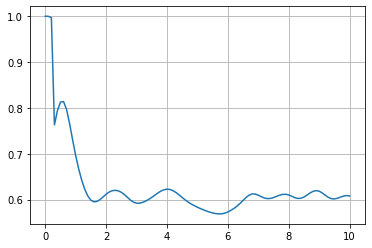

In [20]:
Dist_R=np.sqrt(Y_predict**2+X_predict**2+Z_predict**2)
plt.plot(Time,Dist_R)
plt.grid()